# V5 Changes

Important Version Differences from Previous Version PlioMIP2_Equator_V4:

- Removed experimental cells and redundant checks and figures.
- Added modified cloud albedo plots. 

# IMPORTS

In [1]:
# Importing necessary libraries
import datetime  # For working with dates and times
import os  # For interacting with the operating system
import warnings  # For suppressing warnings

import xesmf as xe
import cartopy.crs as ccrs  # For geographic plotting
import matplotlib as mpl  # Main plotting library
import matplotlib.colors as mcolors  # For working with colors in plots
import matplotlib.pyplot as plt  # For creating plots
from matplotlib.colors import Normalize  # For normalizing colors in plots
import numpy as np  # For numerical computing
import pandas as pd  # For data manipulation and analysis
import scipy.stats as stats  # For statistical analysis
from scipy import stats  # For statistical functions
import seaborn as sns  # For statistical data visualization
import xarray as xr  # For working with labeled multidimensional arrays
from cartopy.util import add_cyclic_point  # For adding cyclic points to data
from sklearn.cluster import KMeans  # For performing K-means clustering
from sklearn.metrics import mean_squared_error  # For calculating mean squared error
from scipy.stats import norm  # For normal distribution functions
from matplotlib.colors import ListedColormap  # For defining a colormap from a list of colors
from matplotlib.colors import LinearSegmentedColormap  # For defining a colormap from a sequence of colors
from matplotlib.colorbar import ColorbarBase  # For creating a colorbar
from sklearn.metrics import silhouette_samples, silhouette_score  # For silhouette analysis

# Configuration options
suppress_warnings = True  # Option to suppress warnings
suppress_plots = False  # Option to suppress plots

# Suppressing warnings if suppress_warnings is True
if suppress_warnings:
    warnings.filterwarnings("ignore")

# Suppressing plots if suppress_plots is True
if suppress_plots:
    import matplotlib
    matplotlib.use("Agg")

# Printing current date and library versions
print(datetime.datetime.ctime(datetime.datetime.today()))  # Print current date and time
print("Matplotlib: ", mpl.__version__)  # Print Matplotlib version
print("Numpy     : ", np.__version__)  # Print NumPy version
print("Pandas   : ", pd.__version__)  # Print Pandas version
print("Xarray   : ", xr.__version__)  # Print Xarray version

Wed Apr 23 16:24:54 2025
Matplotlib:  3.1.1
Numpy     :  1.17.2
Pandas   :  0.25.1
Xarray   :  0.14.0


# OPENING OCEAN TEMP PROXY DATA FILE

In [2]:
# Setting a path to the Excel file
path = '/glade/u/home/nwrye/OceanTemps_Compiles/PlioMIP2data.xlsx'

# Load data from Excel into a pandas DataFrame
df = pd.read_excel(path)

# Selecting specific columns from the DataFrame (longitude, depth, -95%CL, median, 95%CL)
data = df.iloc[:, [1, 2, 3, 4, 5, 6]]

# Convert DataFrame to a numpy array to allow direct indexing and modification
data_array = data.to_numpy()

# Find the indices of the negative values in the first column
negative_indices = data_array[:, 0] < 0

# Add 360 to the negative values using the indices
data_array[negative_indices, 0] += 360

# Convert the modified numpy array back to a DataFrame (if needed)
data_modified = pd.DataFrame(data_array, columns=data.columns)

# Renaming columns
data_modified.columns = ['longitude', 'depth', 'species', 'neg95', 'median', 'pos95']

# Changing the depth value in the first row to 10
data_modified.at[0:1, 'depth'] = 15

# Multiplying all values in the depth column by -1
data_modified['depth'] *= -1

# Replace NaN values in the 'longitude' column with 0 (or any default value)
data_modified['longitude'].fillna(0, inplace=True)

# Round the 'longitude' values to the nearest whole number
data_modified['longitude'] = data_modified['longitude'].round()

# Convert the DataFrame to an xarray Dataset
dsa = data_modified.to_xarray()

# Convert specific columns to desired data types
dsa['depth'] = dsa['depth'].astype('float')
dsa['neg95'] = dsa['neg95'].astype('float')
dsa['median'] = dsa['median'].astype('float')
dsa['pos95'] = dsa['pos95'].astype('float')
dsa['species'] = dsa['species'].astype('str')

# Print the resulting xarray Dataset
print(dsa)

<xarray.Dataset>
Dimensions:    (index: 8)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7
Data variables:
    longitude  (index) float64 265.0 159.0 265.0 159.0 278.0 159.0 249.0 278.0
    depth      (index) float64 -15.0 -15.0 -48.0 -48.0 ... -210.0 -210.0 -210.0
    species    (index) <U10 'alkenones' 'alkenones' ... 'tumida' 'tumida'
    neg95      (index) float64 1.338 0.8068 2.883 0.988 5.799 3.441 3.575 3.678
    median     (index) float64 2.434 1.168 3.257 0.923 6.593 3.8 4.05 4.298
    pos95      (index) float64 4.006 1.326 3.941 0.8945 7.791 4.658 4.726 5.489


# OPENING PLIOMIP2 ANNUAL MEAN OCEAN TEMP DATA FILES 

In [3]:
# Define the directory path for slice files
path = '/glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/'

# List of file names to process for plio files and pi files respectively
pliofile_names = ['CCSM4_plio.nc', 'CESM1.2_plio.nc', 'CESM2_plio.nc', 'COSMOS_plio.nc',
                'EC_Earth3.3_plio.nc', 'HADGEM3_NEW_1997_plio.nc','MIROC4_2004_plio.nc', 'Utrecht_CESM1.0.5_plio.nc','IPSLCM6A_LR_plio.nc', 'GISS_plio.nc',
                'LEEDS_plio.nc', 'NorESM-F_plio.nc','IPSLCM5A_plio.nc', 'IPSLCM5A2_plio.nc']

pifile_names = ['CCSM4_pi.nc', 'CESM1.2_pi.nc',
                'CESM2_pi.nc', 'COSMOS_pi.nc', 'EC_Earth3.3_pi.nc', 'HADGEM3_NEW_1997_pi.nc',
                'MIROC4_2004_pi.nc', 'Utrecht_CESM1.0.5_pi.nc','IPSLCM6A_LR_pi.nc', 'GISS_pi.nc','LEEDS_pi.nc', 'NorESM-F_pi.nc', 'IPSLCM5A_pi.nc', 'IPSLCM5A2_pi.nc' ]

# Create an empty list to store sliced datasets for plio and pi files
pisds = []
pliosds = []

# Open and interpolate plio files
# Iterate through each plio file
for fname in pliofile_names:
    try:
        # Open the NetCDF dataset
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-2, 2), lev=slice(None, 1500))
            
            pliosds.append(sliced)
            # Interpolate the data to the same level values as the first dataset if more than one dataset is present
            if len(pliosds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method='linear')
                pliosds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Open and interpolate pi files
# Iterate through each pi file
for fname in pifile_names:
    try:
        # Open the NetCDF dataset
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-2, 2), lev=slice(None, 1500))
            pisds.append(sliced)
            # Interpolate the data to the same level values as the plio dataset if more than one dataset is present
            if len(pisds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method='linear')
                pisds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Check if both groups of files are on the same lev grid after interpolation
if len(pliosds) > 0 and len(pisds) > 0:
    plio_lev_values = pliosds[0].lev.values
    pi_lev_values = pisds[0].lev.values

    # Check if the level values of plio and pi datasets are the same
    if (plio_lev_values == pi_lev_values).all():
        print("Both groups of files are on the same vertical grid after interpolation.")
    else:
        print("Both groups of files are not on the same vertical grid after interpolation.")
else:
    print("No data found to compare.")

Both groups of files are on the same vertical grid after interpolation.


In [6]:
pisds[0]['lev']

<xarray.DataArray 'lev' (lev: 43)>
array([   5.     ,   15.     ,   25.     ,   35.     ,   45.     ,   55.     ,
         65.     ,   75.     ,   85.     ,   95.     ,  105.     ,  115.     ,
        125.     ,  135.     ,  145.     ,  155.     ,  165.09839,  175.47903,
        186.29126,  197.66026,  209.71138,  222.57828,  236.40883,  251.37015,
        267.6542 ,  285.48364,  305.1192 ,  326.86798,  351.09348,  378.2276 ,
        408.78464,  443.3777 ,  482.7367 ,  527.72797,  579.37286,  638.8626 ,
        707.5633 ,  787.0025 ,  878.8252 ,  984.7058 , 1106.2042 , 1244.5669 ,
       1400.4972 ], dtype=float32)
Coordinates:
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 1106.2042 1244.5669 1400.4972
    time     float64 ...

# HORIZONTAL DIFFERENCE FUNCTION

In [5]:
## Calculates the temp difference between the plio and pi datasets

# Define the function to calculate horizontal temperature difference
def horizontal_difference(plio_ds, pi_ds): 
    
    # Calculate the temperature difference between Pliocene and Preindustrial datasets along the latitude axis
    dif = plio_ds['TEMP'] - pi_ds['TEMP'] 
    diff = dif.mean('lat', skipna=True)
    return diff

# OPENING MMM FILES

In [6]:
# Take the mean across all datasets in the pliosds list
concatenated = xr.concat(pliosds, dim='concat_dim')  # Concatenate datasets along the specified dimension
mean_temp_across_datasets = concatenated['TEMP'].mean(dim='concat_dim')  # Calculate the mean of the 'TEMP' variable across the concatenated datasets

# Create a new xarray dataset
multiplio = xr.Dataset(
    {
        "TEMP": mean_temp_across_datasets  # Add the mean temperature data to the new dataset
    }
)

# Save the dataset to a NetCDF file
output_file_path = "/glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/multimodelmean_plio.nc"  # Specify the output file path
multiplio.to_netcdf(output_file_path)  # Save the dataset to the specified file path

# Confirm the file has been saved
print(f"NetCDF file saved at {output_file_path}")  # Print a confirmation message with the output file path

# Take the mean across all datasets in the pisds list
concatenated = xr.concat(pisds, dim='concat_dim')  # Concatenate datasets along the specified dimension
mean_temp_across_datasets = concatenated['TEMP'].mean(dim='concat_dim')  # Calculate the mean of the 'TEMP' variable across the concatenated datasets

# Create a new xarray dataset
multipi = xr.Dataset(
    {
        "TEMP": mean_temp_across_datasets  # Add the mean temperature data to the new dataset
    }
)

# Save the dataset to a NetCDF file
output_file_path = "/glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/multimodelmean_pi.nc"  # Specify the output file path
multipi.to_netcdf(output_file_path)  # Save the dataset to the specified file path

# Confirm the file has been saved
print(f"NetCDF file saved at {output_file_path}")  # Print a confirmation message with the output file path

NetCDF file saved at /glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/multimodelmean_plio.nc
NetCDF file saved at /glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/multimodelmean_pi.nc


# OPENING TEMPRATURE ANOMALY FILES

In [7]:
opath = "/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/"
anom_names = [
    "CCSM4_anomaly.nc", "CESM1.2_anomaly.nc", "CESM2_anomaly.nc",
    "COSMOS_anomaly.nc", "EC_Earth3.3_anomaly.nc", "HADGEM3_NEW_1997_anomaly.nc",
    "MIROC4_2004_anomaly.nc", "Utrecht_CESM1.0.5_anomaly.nc", "IPSLCM6A_LR_anomaly.nc",
    "GISS_anomaly.nc", "LEEDS_anomaly.nc", "NorESM-F_anomaly.nc",
    "IPSLCM5A_anomaly.nc", "IPSLCM5A2_anomaly.nc"]

anom_files = []

for i in range(len(anom_names)):
    ds = xr.open_dataset(opath + anom_names[i])
    anom_files.append(ds)

####################################################################
# anom_files[14] is the multimodel mean after running this code.
####################################################################

# List of model names for future use
model_names = ["CCSM4", "CESM1.2", "CESM2", "COSMOS", "EC_Earth3.3", "HADGEM3", "MIROC4", "Utrecht", "IPSLCM6A",
               "GISS", "LEEDS", "NorESM-F", "IPSLCM5A", "IPSLCM5A2"]

# Calculate the horizontal difference using the 'horizontal_difference' function
mmm = horizontal_difference(multiplio, multipi)

# Convert the resulting DataArray 'mmm' to a Dataset named 'multi_model_mean'
multi_model_mean = mmm.to_dataset(name="TEMP")

# Print the dataset
print(multi_model_mean)

# Append the multi-model mean dataset to the 'anom_files' list
anom_files.append(multi_model_mean)

mca_path = '/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/Modified_Cloud_Albedo.nc'

mca_ds = xr.open_dataset(mca_path)
#mca_ds =  mca_ds.mean(dim='lat', skipna=True)
anom_files.append(mca_ds)

print(len(anom_files))

<xarray.Dataset>
Dimensions:  (lev: 43, lon: 360)
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 1106.2042 1244.5669 1400.4972
Data variables:
    TEMP     (lev, lon) float64 2.105 2.102 2.096 2.1 ... 2.369 2.37 2.367 2.37
16


# GRABING SPECIES DEPTH HABITAT DATA

In [8]:
# Set the path to the Excel file
excel_path = os.path.join(
    "/glade/u/home/nwrye/OceanTemps_Compiles", "Lakhani_depths.xlsx"
)

# Load data from the Excel file into a pandas DataFrame
df = pd.read_excel(excel_path)

# Filter the DataFrame to include only 'sacculifer', 'dutertrei', and 'tumida' species
selected_species = ["sacculifer", "dutertrei", "tumida"]
df_filtered = df[df["species"].isin(selected_species)]

# Print the filtered DataFrame
print(df_filtered)

         species    lat    long   d18O  calc_depth
729   sacculifer  -1.42  -86.85 -1.255   15.172940
730   sacculifer -12.48  146.88 -1.750   69.602034
731   sacculifer -14.05  147.92 -1.760   71.440652
732   sacculifer  20.12  117.38 -1.915   33.541930
733   sacculifer  19.78  117.53 -1.715   48.747982
...          ...    ...     ...    ...         ...
1853   dutertrei   0.83 -156.87 -0.500  147.743533
1854   dutertrei   1.27 -157.26 -0.940  132.384561
1855   dutertrei   2.46 -159.40 -0.720  145.861499
1856   dutertrei   2.77 -159.29 -0.920  142.029141
1857   dutertrei   2.97 -159.20 -0.820  146.500470

[1129 rows x 5 columns]


# STATISTICAL ANALYSIS

## BIAS FUNCTION

In [9]:
def Bias(o_min, m_max, o_max, m_min):
    """
    Calculate the bias between observational and model data.

    Parameters:
        - o_min: Minimum value from observational data.
        - m_max: Maximum value from model data.
        - o_max: Maximum value from observational data.
        - m_min: Minimum value from model data.

    Returns:
        - prbias: Bias between observational and model data.
    """
    # Calculate the differences
    diff1 = o_min - m_max
    diff2 = m_min - o_max
    
    # Check conditions and calculate prbias
    if diff1 > 0:
        prbias = -diff1
    elif diff2 > 0:
        prbias = diff2
    elif np.isnan(diff1) or np.isnan(diff2):
        prbias = np.nan
    else:
        prbias = 0
        
    return prbias

## CREATING MAX AND MIN DATA ARRAY FOR EACH SPECIES

In [10]:
# Extract relevant columns for the xarray dataset
selected_columns = ["longitude", "species", "calc_depth"]
lon_sites = dsa["longitude"]

# Exclude first two sites (alkenones) as there is no depth presence distribution for them
xpositions = np.array(lon_sites)

species_sites = dsa["species"]

# Create a list of arrays where each array contains 'calc_depth' values for a specific species
violin_data = [
    df_filtered[df_filtered["species"] == species_sites[i]]["calc_depth"].values
    for i in range(len(xpositions))
]

# The depth is the surrounding vertical grid cells which, after interpolation, start at 5m and 25m
prescribed_alk_depth = [5, 25]

# Changing the alkenones data
violin_data[0] = prescribed_alk_depth
violin_data[1] = prescribed_alk_depth

# Make sure that the first two index for alkenones species have prescribed calc_depths of 5 and 25m

# Initialize empty arrays for minimum and maximum values
min_values = np.empty(len(violin_data))
max_values = np.empty(len(violin_data))

# Loop through each indexed array in violin_data
for i, data_array in enumerate(violin_data):
    # Find minimum and maximum values for the current array
    min_values[i] = np.round(np.min(data_array), 2)
    max_values[i] = np.round(np.max(data_array), 2)

# Create xarray DataArray for both min and max values
min_max_values_da = xr.DataArray(
    data=np.vstack((min_values, max_values)),
    dims=("stat", "index"),
    coords={"stat": ["min_depth", "max_depth"], "index": range(len(min_values))},
)

# Print out max and min depth values for each species 
print("Min and Max Depth Values for Each Species Array:")
print(min_max_values_da)

Min and Max Depth Values for Each Species Array:
<xarray.DataArray (stat: 2, index: 8)>
array([[  5.  ,   5.  ,   0.  ,   0.  ,  21.35,  82.7 ,  82.7 ,  82.7 ],
       [ 25.  ,  25.  , 232.27, 232.27, 592.43, 747.84, 747.84, 747.84]])
Coordinates:
  * stat     (stat) <U9 'min_depth' 'max_depth'
  * index    (index) int64 0 1 2 3 4 5 6 7


## CREATING A COMBINED DATASET WITH MODELS, SPECIES, WITH SPECIES MAX, MIN, AND LONGITUDE

In [11]:
# Create xarray Dataset
combined_dataset = xr.Dataset(
    data_vars={"min_depth": ("species", min_max_values_da.sel(stat="min_depth")),
                "max_depth": ("species", min_max_values_da.sel(stat="max_depth")),
                "longitude": ("species", xpositions)},
    coords={"species": ["alkenones", "alkenones", "sacculifer", "sacculifer", "dutertrei", "tumida", "tumida", "tumida"]}
)

# Remove the time coordinate if it exists
if "time" in combined_dataset.coords:
    combined_dataset = combined_dataset.drop_vars("time")

# Print or use the modified dataset as needed
print(combined_dataset)

model_names = ["CCSM4", "CESM1.2", "CESM2", "COSMOS", "EC_Earth3.3", "HADGEM3",
               "MIROC4", "Utrecht", "IPSLCM6A", "GISS", "LEEDS", "NorESM-F", "IPSLCM5A", "IPSLCM5A2", "MMM", "MCA"]

# Create an empty xarray Dataset
model_dataset = xr.Dataset()

for i, model_name in enumerate(model_names):
    data = anom_files[i]["TEMP"]

    model_dataset[model_name] = data  # Add the data variable to the Dataset

# Remove the time coordinate if it exists in the second dataset
if "time" in model_dataset.coords:
    model_dataset = model_dataset.drop("time")

# Print or use the resulting model_dataset
print(model_dataset)
model_dataset.to_netcdf('/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/all_models.nc')

<xarray.Dataset>
Dimensions:    (species: 8)
Coordinates:
  * species    (species) <U10 'alkenones' 'alkenones' ... 'tumida' 'tumida'
Data variables:
    min_depth  (species) float64 5.0 5.0 0.0 0.0 21.35 82.7 82.7 82.7
    max_depth  (species) float64 25.0 25.0 232.3 232.3 592.4 747.8 747.8 747.8
    longitude  (species) float64 265.0 159.0 265.0 159.0 278.0 159.0 249.0 278.0
<xarray.Dataset>
Dimensions:      (lev: 43, lon: 360)
Coordinates:
  * lev          (lev) float64 5.0 15.0 25.0 ... 1.106e+03 1.245e+03 1.4e+03
  * lon          (lon) int64 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
Data variables:
    CCSM4        (lev, lon) float64 ...
    CESM1.2      (lev, lon) float32 ...
    CESM2        (lev, lon) float32 ...
    COSMOS       (lev, lon) float64 ...
    EC_Earth3.3  (lev, lon) float32 ...
    HADGEM3      (lev, lon) float64 ...
    MIROC4       (lev, lon) float64 ...
    Utrecht      (lev, lon) float32 ...
    IPSLCM6A     (lev, lon) float32 ...
    GISS         (l

## FINDING THE MIN AND MAX TEMP IN EACH MODEL BASED ON THE DEPTH MAX AND MIN OF EACH SPECIES AT THEIR DESIGNATED LONGITUDE
##  ALSO CALCULATES THE BIAS AND RMSB OF EACH SPECIES FOR EACH MODEL AND ADDS TO THE DATA ARRAY

In [12]:
num_species = len(combined_dataset["species"])
num_models = len(model_names)

min_temps = np.zeros((num_species, num_models))
max_temps = np.zeros((num_species, num_models))

# Looping through each species
for i, species in enumerate(combined_dataset["species"]):
    # Looping each Longitude with every species change
    species_lon = combined_dataset["longitude"].isel(species=i).item()

    # Find the min and max depth for the species at the specified longitude
    min_depth = combined_dataset["min_depth"].isel(species=i).item()
    max_depth = combined_dataset["max_depth"].isel(species=i).item()

    # print(f"\nSpecies: {species}, Longitude: {species_lon}, Min Depth: {min_depth}, Max Depth: {max_depth}")

    # Looping through all models for the current species
    for j, model in enumerate(model_names):
        # print(f"\nModel: {model}")

        # Filter model_dataset within the specified depth range and longitude for the current model and species
        filtered_dataset = model_dataset[model].sel(
            lev=slice(min_depth, max_depth), lon=species_lon
        )

        # print("Filtered Dataset:")
        # print(filtered_dataset)

        # Find the min and max values for the current model and species along the 'lev' dimension only
        max_values = filtered_dataset.max(dim="lev").values
        min_values = filtered_dataset.min(dim="lev").values

        # print(f"Min values: {min_values}, Max values: {max_values}")

        # Save max and min values in the arrays
        max_temps[i, j] = max_values
        min_temps[i, j] = min_values

# Create an xarray dataset with the resulting arrays
result_dataset = xr.Dataset(
    {"min_temps": (["species", "models"], min_temps),
     "max_temps": (["species", "models"], max_temps),
     "species_lon": (["species"], combined_dataset["longitude"])},
    coords={"species": combined_dataset["species"], "models": model_names}
)
# Display the resulting xarray dataset
#print("\nResult Dataset:")
#print(result_dataset)

lower_bound = dsa["neg95"]
upper_bound = dsa["pos95"]
#print(lower_bound)
#print(upper_bound)

# Create an empty array for bias values
bias_values = np.zeros((num_species, num_models))

# Loop through each species and model
for i, species in enumerate(result_dataset["species"]):
    for j, model in enumerate(result_dataset["models"]):
        # Get the min and max values from the result_dataset
        o_min = lower_bound[i].item()
        m_max = result_dataset["max_temps"].isel(species=i, models=j).item()
        o_max = upper_bound[i].item()
        m_min = result_dataset["min_temps"].isel(species=i, models=j).item()

        # Calculate the bias using the Bias function
        bias_value = Bias(o_min, m_max, o_max, m_min)

        # Save bias value in the array
        bias_values[i, j] = bias_value

# Add the bias values as a new data variable in the result_dataset
result_dataset["Bias"] = (["species", "models"], bias_values)

# Calculate RMSB for each model
rmsb_values = np.sqrt(np.nanmean(bias_values**2, axis=0))

# Add RMSE values as a new data variable in the result_dataset
result_dataset["RMSB"] = (["models"], rmsb_values)

# Display the updated result_dataset
print("\nUpdated Result Dataset with Bias and RMSB:")
print(result_dataset)


Updated Result Dataset with Bias and RMSB:
<xarray.Dataset>
Dimensions:      (models: 16, species: 8)
Coordinates:
  * species      (species) <U10 'alkenones' 'alkenones' ... 'tumida' 'tumida'
  * models       (models) <U11 'CCSM4' 'CESM1.2' 'CESM2' ... 'MMM' 'MCA'
Data variables:
    min_temps    (species, models) float64 1.405 2.763 4.064 ... 0.354 1.76 3.81
    max_temps    (species, models) float64 1.684 2.854 4.669 ... 2.205 4.19
    species_lon  (species) float64 265.0 159.0 265.0 159.0 ... 159.0 249.0 278.0
    Bias         (species, models) float64 0.0 0.0 0.05733 ... -2.429 -1.473 0.0
    RMSB         (models) float64 1.75 1.173 1.018 1.698 ... 2.179 1.56 1.106


In [13]:
'''
This code iterates over each model in the result_dataset, converts the subset of data for each model to a Pandas DataFrame, 
selects only the desired columns specified in desired_columns, drops any duplicate rows, and prints the resulting DataFrame for each model.
'''

# Define a list of columns you want to keep
desired_columns = ['Bias', 'species_lon']

# Iterate over each model
for model in result_dataset.models:
    # Access data for the current model
    model_data = result_dataset.sel(models=model)
    
    # Convert the subset to a Pandas DataFrame and reset the index
    model_dataframe = model_data.to_dataframe().reset_index()
    
    # Select only the desired columns
    model_dataframe_subset = model_dataframe[desired_columns]
    
    # Drop duplicates if any
    model_dataframe_subset = model_dataframe_subset.drop_duplicates()
    
    # Print the data for the current model
    #print(f"Model: {model}")
    #print(model_dataframe_subset)
    #print("\n")

# GENERATING RGBA VALUES FOR VIOLIN PLOTS

In [14]:
# Function to generate color swatches
def generate_color_swatches(values):
    # Initialize an empty list to store RGBA values
    rgba_values = []

    # Define your contour levels
    contour_levels = [-1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0]

    # Define your custom colors and normalize them to the range [0, 1]
    colors = [
        (5/255, 48/255, 97/255),     # Very Dark Blue
        (33/255, 102/255, 172/255),  # Dark Blue
        (106/255, 169/255, 204/255), # Blue
        (177/255, 213/255, 231/255), # Light Blue
        (196/255, 217/255, 235/255), # Light Blue
        (209/255, 229/255, 240/255), # Very Light Blue
        (253/255, 219/255, 199/255), # Very Light Orange
        (249/255, 206/255, 182/255), # Light Orange
        (245/255, 193/255, 165/255), # Light Orange
        (241/255, 180/255, 148/255), # Light Orange
        (236/255, 167/255, 131/255), # Light Orange
        (232/255, 154/255, 114/255), # Light Orange
        (228/255, 141/255, 97/255),  # Light Orange
        (224/255, 128/255, 80/255),  # Light Orange
        (220/255, 115/255, 63/255),  # Light Orange
        (215/255, 102/255, 46/255),  # Light Orange
        (211/255, 89/255, 29/255),   # Light Orange
        (207/255, 76/255, 12/255),   # Light Red
        (203/255, 63/255, 5/255),    # Light Red
        (199/255, 50/255, 5/255),    # Light Red
        (195/255, 37/255, 5/255),    # Light Red
        (191/255, 24/255, 5/255),    # Light Red
        (187/255, 11/255, 5/255),    # Dark Red
        (183/255, 0/255, 18/255),    # Dark Reddish Purple
        (179/255, 0/255, 35/255),    # Dark Purple
        (175/255, 0/255, 51/255),    # Deep Purple
        (171/255, 0/255, 68/255),    # Deep Blueish Purple
        (167/255, 0/255, 85/255),    # Deep Blue Purple
        (162/255, 0/255, 102/255),   # Deep Blue Purple
        (158/255, 0/255, 119/255),   # Deep Blue Purple
        (154/255, 0/255, 136/255),   # Deep Blue Purple
        (150/255, 0/255, 153/255),   # Deep Blue Purple
        (146/255, 0/255, 170/255),   # Deep Blue Purple
        (142/255, 0/255, 187/255),   # Deep Blue Purple
        (138/255, 0/255, 204/255),   # Deep Blue Purple
    ]

    # Create a custom colormap
    cmap = ListedColormap(colors)

        # Set the normalization
    norm = plt.Normalize(vmin=-1.5, vmax=7)
    
    # Map the input values to the colormap
    rgba_values = cmap(norm(values))
    
    return rgba_values

# Generate color swatches for each column
neg95rgba_values = generate_color_swatches(dsa['neg95'])
medrgba_values = generate_color_swatches(dsa['median'])
pos95rgba_values = generate_color_swatches(dsa['pos95'])

neg95rgba_values = neg95rgba_values[2:]
pos95rgba_values = pos95rgba_values[2:]
medrgba_values = medrgba_values[2:]

#print(neg95rgba_values)
#print(medrgba_values)
#print(pos95rgba_values)
#print(len(neg95rgba_values))
#print(len(medrgba_values))
#print(len(pos95rgba_values))

In [15]:
################################################################################################################

def plot_slice(X, Y, Z, title):
    # Create a new figure with a specified size
    fig = plt.figure(figsize=(11, 6.5))

    # Get the 'coolwarm' colormap from matplotlib
    cmap = plt.get_cmap('coolwarm')

    # Define a normalization for the color scale based on specified min and max values
    norm = colors.Normalize(vmin=-2, vmax=38)

    # Plot the data using filled contours
    # X, Y, and Z are the data arrays for the x, y, and z dimensions of the plot
    # levels=10 specifies the number of contour levels
    # cmap specifies the colormap to be used
    # norm specifies the normalization for the color scale
    cs = plt.contourf(X, Y, Z, levels=10, cmap=cmap, norm=norm)

    # Add a colorbar to the plot
    # shrink=0.6 reduces the size of the colorbar
    # orientation='horizontal' places the colorbar below the plot
    # label='SST (Celcius)' sets the label for the colorbar
    cbar = plt.colorbar(cs, shrink=0.6, orientation='horizontal', label='SST (Celcius)')

    # Set the title of the plot using the provided 'title' parameter
    plt.title(title)

    # Display the plot
    plt.show()

# Example usage:
# Replace X, Y, and Z with your actual data arrays
# Replace 'Title of the Plot' with your desired plot title
# plot_slice(X, Y, Z, 'Title of the Plot')

################################################################################################################

def plot_projection(X, Y, Z, title):
    # Create a figure with a specified size
    fig = plt.figure(figsize=(11, 6.5))

    # Set the axes using the Robinson projection
    ax = plt.axes(projection=ccrs.Robinson())

    # Set the colormap and normalization
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(vmin=-2, vmax=38)

    # Add cyclic point to the data for smooth plotting
    # 'Z' is the data, 'coord=X' specifies the X coordinate to be cyclic
    Z, lons = add_cyclic_point(Z, coord=X)

    # Plot the data using filled contours
    # 'lons' are the longitudes after adding cyclic points
    # 'Y' is the y-coordinate, 'Z' is the data
    # 'transform=ccrs.PlateCarree()' specifies the PlateCarree projection for the data
    cs = ax.contourf(lons, Y, Z, levels=10, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    # Add coastlines to the plot
    ax.coastlines()

    # Add colorbar to the plot
    # 'shrink=0.6' reduces the size of the colorbar
    # 'orientation='horizontal'' places the colorbar below the plot
    # 'label='SST (Celsius)'' sets the label for the colorbar
    cbar = plt.colorbar(cs, shrink=0.6, orientation='horizontal', label='SST (Celsius)')

    # Set the title of the plot
    plt.title(title)

    # Display the plot
    plt.show()

# Example usage:
# Replace X, Y, and Z with your actual data arrays
# Replace 'Title of the Plot' with your desired plot title
# plot_projection(X, Y, Z, 'Title of the Plot')

################################################################################################################

def scatterplot(X, Y, diff, title, neg95, pos95, med, scatter_X, scatter_Y):
    
    """
    Function to create a combined scatter plot with temperature contour.

    Parameters:
    X (array-like): Array of x-axis values (longitude).
    Y (array-like): Array of y-axis values (depth).
    diff (array-like): Array of temperature differences.
    title (str): Title for the plot.
    neg95 (array-like): Array of values for the negative 95th percentile.
    pos95 (array-like): Array of values for the positive 95th percentile.
    med (array-like): Array of median values.
    scatter_X (array-like): Array of x-axis values for scatter points.
    scatter_Y (array-like): Array of y-axis values for scatter points.
    """

    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15, 5))

    # Define contour levels and colormap for the temperature contour plot
    contour_levels = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    cmap = plt.get_cmap('coolwarm', 21)  # Choose the 'coolwarm' colormap with 21 levels
    norm = plt.Normalize(vmin=-5, vmax=5)  # Normalize the colormap for specified min and max values

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([0, -800])
    ax.invert_yaxis()

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')

    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    ax.scatter(scatter_X, scatter_Y, c=neg95, marker='o', s=150, cmap=cmap, vmin=-5, vmax=5, edgecolors='k')
    ax.scatter(scatter_X, scatter_Y, c=med, marker='o', s=75, cmap=cmap, vmin=-5, vmax=5)
    ax.scatter(scatter_X, scatter_Y, c=pos95, marker='o', s=15, cmap=cmap, vmin=-5, vmax=5)

    # Set the title for the combined plot
    ax.set_title(title)

    # Set the font size of tick labels on both x and y axes for the combined plot
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Replace X, Y, diff, title, neg95, pos95, med, scatter_X, and scatter_Y with your actual data arrays
# scatterplot(X, Y, diff, title, neg95, pos95, med, scatter_X, scatter_Y)

################################################################################################################

def violinplot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites):
    """
    Function to create a combined plot with temperature contour and violin plots.

    Parameters:
    X (array-like): Array of x-axis values (longitude).
    Y (array-like): Array of y-axis values (depth).
    diff (array-like): Array of temperature differences.
    title (str): Title for the plot.
    pos95 (array-like): Array of values for the positive 95th percentile.
    med (array-like): Array of median values.
    neg95 (array-like): Array of values for the negative 95th percentile.
    lon_sites (array-like): Array of longitude values for sites.
    species_sites (array-like): Array of species names for sites.
    """

    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15, 5))

    # Define contour levels and colormap for the temperature contour plot
    contour_levels = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    cmap = plt.get_cmap('coolwarm', 21)
    norm = plt.Normalize(vmin=-5, vmax=5)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')

    # Set the title for the combined plot
    ax.set_title(title)

    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    species_sites_noAlks = species_sites[2:]

    # Define custom positions for the violin plots on the x-axis
    xpositions = np.array(lon_sites[2:])

    # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):

        # Create the violin plot with a custom color for the negative 95th percentile
        parts = ax.violinplot(-neg95[i], [np.array(xpositions[i])], vert=True, widths=9, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(neg95rgba_values[i])  # Assign the custom color
            pc.set_edgecolor('black')  # Set the edge color to black
            pc.set_alpha(0.3)

        # Create the violin plot with a custom color for the median
        parts1 = ax.violinplot(-med[i], [np.array(xpositions[i])], vert=True, widths=6, showextrema=False)
        for pc in parts1['bodies']:
            pc.set_facecolor(medrgba_values[i])  # Assign the custom color
            pc.set_alpha(0.4)

        # Create the violin plot with a custom color for the positive 95th percentile
        parts2 = ax.violinplot(-pos95[i], [np.array(xpositions[i])], vert=True, widths=2.5, showextrema=False)
        for pc in parts2['bodies']:
            pc.set_facecolor(pos95rgba_values[i])  # Assign the custom color
            pc.set_alpha(1)

    # Show the plot
    plt.show()

################################################################################################################

In [16]:
# Define a variable needed for the function below
alk_sites = dsa.where(dsa['species'] == 'alkenones', drop=True)  # This variable is needed to be set before using Combined Plot function

def plot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites, scatter_X, scatter_Y, scatter_med, scatter_pos95, scatter_neg95, rmsb, fig_name):
    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15, 5))

    # Define your contour levels
    contour_levels = [-1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0]

    # Define your custom colors and normalize them to the range [0, 1]
    colors = [
        (5/255, 48/255, 97/255),     # Very Dark Blue
        (33/255, 102/255, 172/255),  # Dark Blue
        (106/255, 169/255, 204/255), # Blue
        (177/255, 213/255, 231/255), # Light Blue
        (196/255, 217/255, 235/255), # Light Blue
        (209/255, 229/255, 240/255), # Very Light Blue
        (253/255, 219/255, 199/255), # Very Light Orange
        (249/255, 206/255, 182/255), # Light Orange
        (245/255, 193/255, 165/255), # Light Orange
        (241/255, 180/255, 148/255), # Light Orange
        (236/255, 167/255, 131/255), # Light Orange
        (232/255, 154/255, 114/255), # Light Orange
        (228/255, 141/255, 97/255),  # Light Orange
        (224/255, 128/255, 80/255),  # Light Orange
        (220/255, 115/255, 63/255),  # Light Orange
        (215/255, 102/255, 46/255),  # Light Orange
        (211/255, 89/255, 29/255),   # Light Orange
        (207/255, 76/255, 12/255),   # Light Red
        (203/255, 63/255, 5/255),    # Light Red
        (199/255, 50/255, 5/255),    # Light Red
        (195/255, 37/255, 5/255),    # Light Red
        (191/255, 24/255, 5/255),    # Light Red
        (187/255, 11/255, 5/255),    # Dark Red
        (183/255, 0/255, 18/255),    # Dark Reddish Purple
        (179/255, 0/255, 35/255),    # Dark Purple
        (175/255, 0/255, 51/255),    # Deep Purple
        (171/255, 0/255, 68/255),    # Deep Blueish Purple
        (167/255, 0/255, 85/255),    # Deep Blue Purple
        (162/255, 0/255, 102/255),   # Deep Blue Purple
        (158/255, 0/255, 119/255),   # Deep Blue Purple
        (154/255, 0/255, 136/255),   # Deep Blue Purple
        (150/255, 0/255, 153/255),   # Deep Blue Purple
        (146/255, 0/255, 170/255),   # Deep Blue Purple
        (142/255, 0/255, 187/255),   # Deep Blue Purple
        (138/255, 0/255, 204/255),   # Deep Blue Purple
    ]

    # Create a custom colormap
    cmap = ListedColormap(colors)

    # Set the normalization
    norm = plt.Normalize(vmin=-1.5, vmax=7)

    # Clip values above -1.5 to 7 for the temperature differences array
    diff_clipped = np.clip(diff, -1.5, 7)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the clipped temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff_clipped, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')
    cbar.set_ticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7])

    # Set the title for the combined plot
    ax.set_title(f"{title} ({rmsb})")
    
    # Remove alkenones
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    species_sites_noAlks = species_sites[2:] 

    # Define custom positions for the violin plots on the x-axis
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    xpositions = np.array(lon_sites[2:])

    # Extract depth data for each species for violin plots
    violin_data = [df_filtered[df_filtered['species'] == species_sites_noAlks[i]]['calc_depth'].values for i in range(len(xpositions))]   

    # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):
        
        # Create the violin plot with a custom color for the negative 95th percentile
        parts = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=9, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(neg95rgba_values[i])  # Assign the custom color
            pc.set_edgecolor('black')  # Set the edge color to black
            pc.set_alpha(1)
        
        # Create the violin plot with a custom color for the median
        parts1 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=5, showextrema=False)
        for pc in parts1['bodies']:
            pc.set_facecolor(medrgba_values[i])  # Assign the custom color
            pc.set_alpha(1)
        
        # Create the violin plot with a custom color for the positive 95th percentile
        parts2 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=2.5, showextrema=False)
        for pc in parts2['bodies']:
            pc.set_facecolor(pos95rgba_values[i])  # Assign the custom color
            pc.set_alpha(1)
            
    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    scatter_kwargs = {"marker": "o", "cmap": cmap, "vmin": -1.5, "vmax": 7}
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_neg95[0], scatter_neg95[1]], s=150, edgecolors="k", **scatter_kwargs)
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_med[0], scatter_med[1]], s=60, **scatter_kwargs)
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_pos95[0], scatter_pos95[1]], s=15, **scatter_kwargs)

    # Setting output path
    path = '/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/'

    # Save the figure as a large image file (e.g., PNG)
    plt.savefig(path + fig_name, dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()
    
################################################################################################################

# FULL 7x2 COMPARISON PLOT

In [33]:
def gridplot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites, scatter_X, scatter_Y, scatter_med, scatter_pos95, scatter_neg95, rmsb, ax=None):
    """
    Function to create a combined plot with temperature contour, violin plots, and scatter points.

    Parameters:
    X (array-like): Array of x-axis values (longitude).
    Y (array-like): Array of y-axis values (depth).
    diff (array-like): Array of temperature differences.
    title (str): Title for the plot.
    pos95 (array-like): Array of values for the positive 95th percentile.
    med (array-like): Array of median values.
    neg95 (array-like): Array of values for the negative 95th percentile.
    lon_sites (array-like): Array of longitude values for sites.
    species_sites (array-like): Array of species names for sites.
    scatter_X (array-like): Array of x-axis values for scatter points.
    scatter_Y (array-like): Array of y-axis values for scatter points.
    scatter_med (array-like): Array of median values for scatter points.
    scatter_pos95 (array-like): Array of values for the positive 95th percentile for scatter points.
    scatter_neg95 (array-like): Array of values for the negative 95th percentile for scatter points.
    rmsb (float): RMSB value to be included in the title.
    ax (matplotlib.axes._subplots.AxesSubplot): Axes on which to plot. If None, a new figure and axis will be created.

    Returns:
    cs (matplotlib.contour.QuadContourSet): Contour set for color mapping.
    """
    # If ax is not provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 12))

    # Define your contour levels
    contour_levels = [-1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0]


    # Define your custom colors and normalize them to the range [0, 1]
    colors = [
        (5/255, 48/255, 97/255),     # Very Dark Blue
        (33/255, 102/255, 172/255),  # Dark Blue
        (106/255, 169/255, 204/255), # Blue
        (177/255, 213/255, 231/255), # Light Blue
        (196/255, 217/255, 235/255), # Light Blue
        (209/255, 229/255, 240/255), # Very Light Blue
        (253/255, 219/255, 199/255), # Very Light Orange
        (249/255, 206/255, 182/255), # Light Orange
        (245/255, 193/255, 165/255), # Light Orange
        (241/255, 180/255, 148/255), # Light Orange
        (236/255, 167/255, 131/255), # Light Orange
        (232/255, 154/255, 114/255), # Light Orange
        (228/255, 141/255, 97/255),  # Light Orange
        (224/255, 128/255, 80/255),  # Light Orange
        (220/255, 115/255, 63/255),  # Light Orange
        (215/255, 102/255, 46/255),  # Light Orange
        (211/255, 89/255, 29/255),   # Light Orange
        (207/255, 76/255, 12/255),   # Light Red
        (203/255, 63/255, 5/255),    # Light Red
        (199/255, 50/255, 5/255),    # Light Red
        (195/255, 37/255, 5/255),    # Light Red
        (191/255, 24/255, 5/255),    # Light Red
        (187/255, 11/255, 5/255),    # Dark Red
        (183/255, 0/255, 18/255),    # Dark Reddish Purple
        (179/255, 0/255, 35/255),    # Dark Purple
        (175/255, 0/255, 51/255),    # Deep Purple
        (171/255, 0/255, 68/255),    # Deep Blueish Purple
        (167/255, 0/255, 85/255),    # Deep Blue Purple
        (162/255, 0/255, 102/255),   # Deep Blue Purple
        (158/255, 0/255, 119/255),   # Deep Blue Purple
        (154/255, 0/255, 136/255),   # Deep Blue Purple
        (150/255, 0/255, 153/255),   # Deep Blue Purple
        (146/255, 0/255, 170/255),   # Deep Blue Purple
        (142/255, 0/255, 187/255),   # Deep Blue Purple
        (138/255, 0/255, 204/255),   # Deep Blue Purple
    ]

    # Create a custom colormap
    cmap = ListedColormap(colors)

        # Set the normalization
    norm = plt.Normalize(vmin=-1.5, vmax=7)

    # Clip values above 5 to 5 for the temperature differences array
    diff_clipped = np.clip(diff, -1.5, 5)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=10)
    ax.set_xlabel("Longitude", fontsize=10)

    # Plot the clipped temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff_clipped, levels=contour_levels, cmap=cmap, norm=norm)

    # Set the title for the combined plot with rmsb
    ax.set_title(f"{title} ({rmsb})")

    # Remove alkenones
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    species_sites_noAlks = species_sites[2:]

    # Define custom positions for the violin plots on the x-axis
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    xpositions = np.array(lon_sites[2:])

    # Extract depth data for each species for violin plots
    violin_data = [
        df_filtered[df_filtered["species"] == species_sites_noAlks[i]][
            "calc_depth"
        ].values
        for i in range(len(xpositions))
    ]
        # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):
        # Create violins with custom colors for negative 95th percentile, median, and positive 95th percentile
        for j, width, color in zip(range(3), [9, 6, 2.5], [neg95rgba_values[i], medrgba_values[i], pos95rgba_values[i]]):
            parts = ax.violinplot(
                -violin_data[i],
                [np.array(xpositions[i])],
                vert=True,
                widths=width,
                showextrema=False,
            )
            for pc in parts["bodies"]:
                pc.set_facecolor(color)  # Assign the custom color
                if j == 0:
                    pc.set_edgecolor("black")
                pc.set_alpha(1)

    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    scatter_kwargs = {"marker": "o", "cmap": cmap, "vmin": -1.5, "vmax": 7}
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_neg95[0], scatter_neg95[1]], s=150, edgecolors="k", **scatter_kwargs)
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_med[0], scatter_med[1]], s=60, **scatter_kwargs)
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_pos95[0], scatter_pos95[1]], s=15, **scatter_kwargs)

    # If ax is not provided, show the plot
    if ax is None:
        plt.show()

    return cs

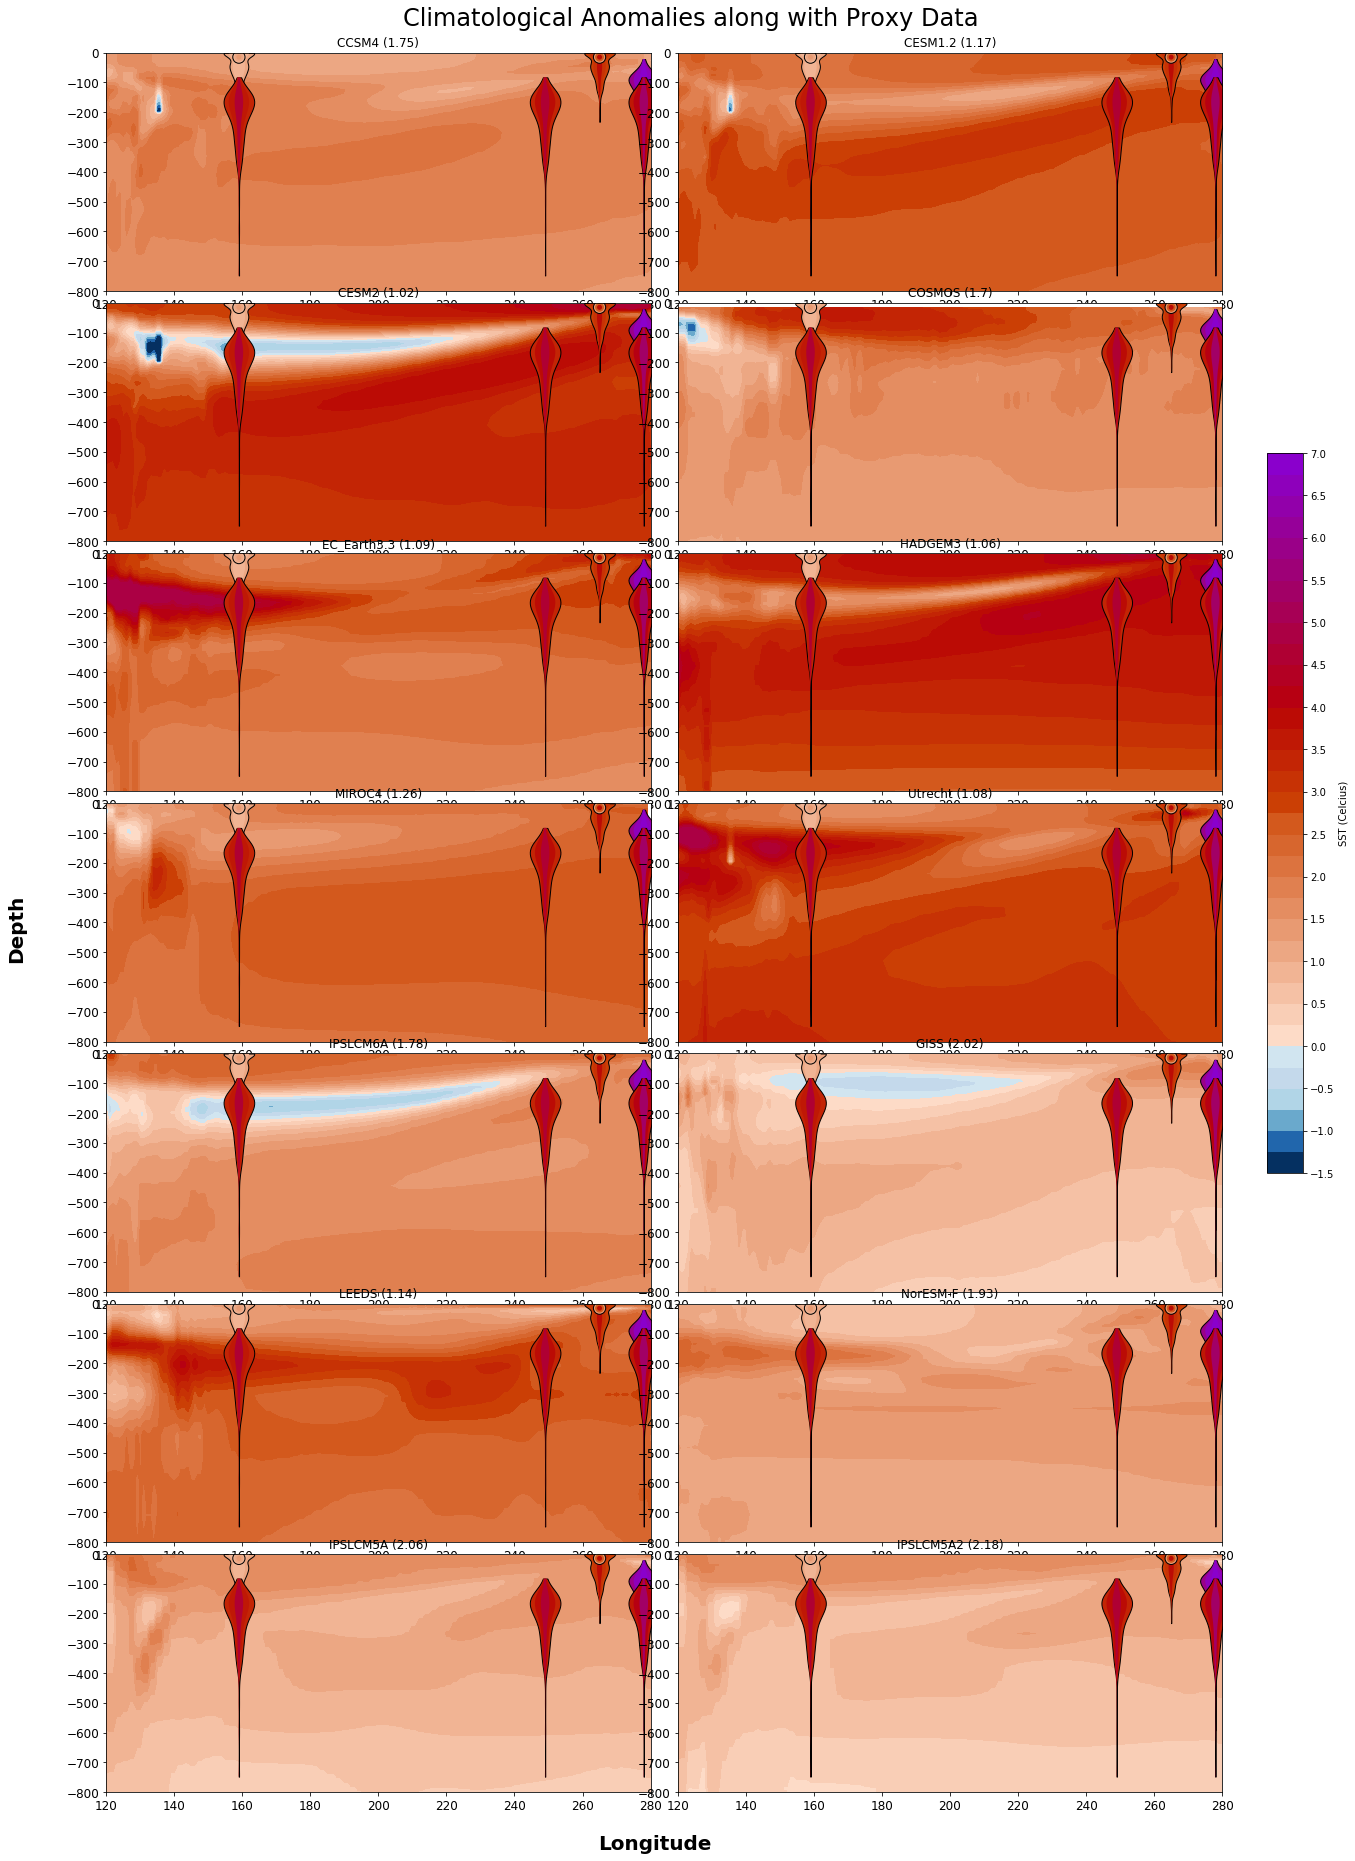

In [62]:
# List of model names
model_names = ['CCSM4', 'CESM1.2', 'CESM2', 'COSMOS', 'EC_Earth3.3', 'HADGEM3', 'MIROC4', 'Utrecht',
               'IPSLCM6A', 'GISS', 'LEEDS', 'NorESM-F', 'IPSLCM5A', 'IPSLCM5A2']

alk_sites = dsa.where(dsa['species'] == 'alkenones', drop=True)

fig, axes = plt.subplots(7, 2, figsize=(25, 32), gridspec_kw={"hspace": 0.05, "wspace": 0.05})
axes = axes.flatten()

# Iterate over each model name and corresponding data
for i, model_name in enumerate(model_names):
    # Call your gridplot function with specific arguments for the current model
    cs = gridplot(
        pliosds[i].lon,
        -pliosds[i]["lev"],
        horizontal_difference(pliosds[i], pisds[i]),
        title=model_names[i],
        pos95=dsa["pos95"],
        med=dsa["median"],
        neg95=dsa["neg95"],
        lon_sites=dsa["longitude"],
        species_sites=dsa["species"],
        scatter_X=alk_sites["longitude"],
        scatter_Y=alk_sites["depth"],
        scatter_med=alk_sites["median"],
        scatter_pos95=alk_sites["pos95"],
        scatter_neg95=alk_sites["neg95"],
        ax=axes[i],
        rmsb=round(float(result_dataset["RMSB"][i]), 2),
    )
# Create a colorbar for the entire plot
cbar = fig.colorbar(cs, ax=axes, orientation="vertical", label="SST (Celcius)")

# Set an overall title with increased font size
fig.suptitle("Climatological Anomalies along with Proxy Data", fontsize=24, y=0.90, x=0.45)

# Adjust layout with less whitespace
plt.tight_layout(rect=[0, 0.08, 1, 0.9])

# Shared axis labels with X label moved up
fig.text(0.43, 0.1, 'Longitude', ha='center', fontsize=20, fontweight='bold')
fig.text(0.07, 0.5, 'Depth', va='center', rotation='vertical', fontsize=20, fontweight='bold')

# Adjust colorbar position
cbar.ax.set_position([0.77, 0.1, 0.02, 0.9])
cbar.set_ticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7])


# Save and show
plt.savefig(path + "fullplotgrid.pdf", dpi=300, bbox_inches="tight")
plt.show()

| Cluster 0 | Cluster 1 | Cluster 2  |
|------------|-----------|-----------|
| CESM1.2    | CCSM4     | IPSLCM5A  |
| CESM2      | COSMOS    | GISS      |
| EC_Earth3.3| IPSLCM6A  | NorESM-F  |
| HADGEM3    |           | IPSLCM5A2 |
| MIROC4     |           |           |
| Utrecht    |           |           |
|  LEEDS     |           |           |      |           |


# CLUSTER ANALYSIS (K-CLUSTERING)

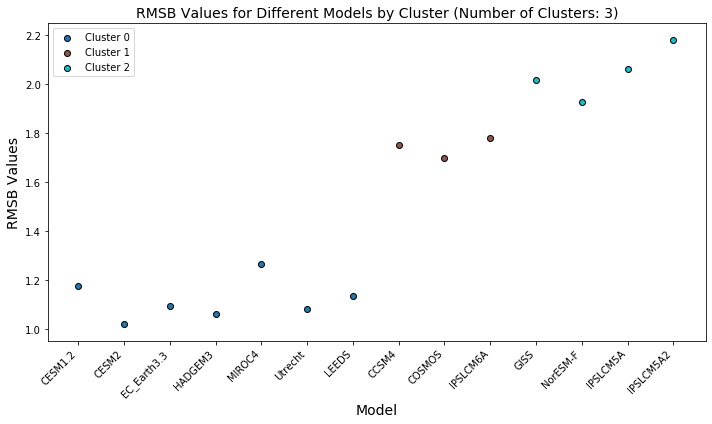

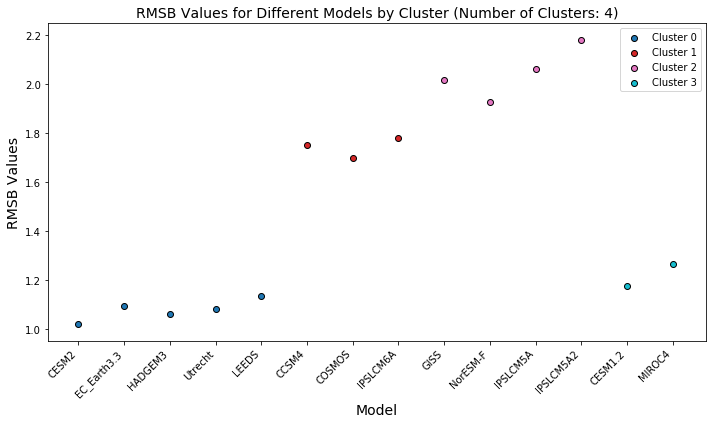

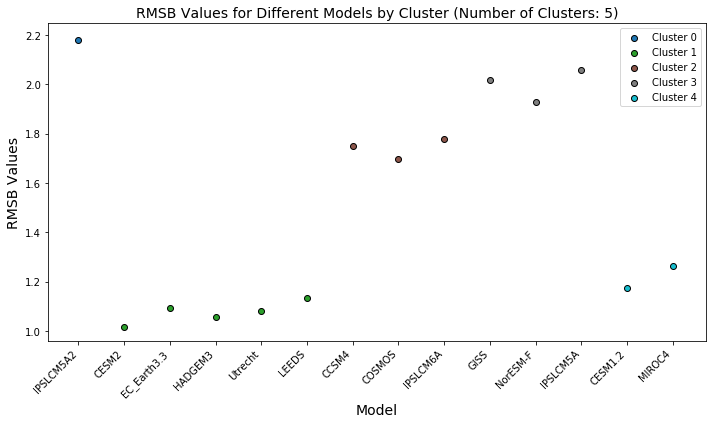

In [32]:
# Modify the "RMSB" key by removing the last element
rmsb = result_dataset["RMSB"][:-2]

# Provided model_names
model_names = ['CCSM4', 'CESM1.2', 'CESM2', 'COSMOS', 'EC_Earth3.3', 'HADGEM3', 'MIROC4', 'Utrecht',
               'IPSLCM6A', 'GISS', 'LEEDS', 'NorESM-F', 'IPSLCM5A', 'IPSLCM5A2'][:len(rmsb)]  # Trim model_names to match rmsb length

# Create a new dataset as a Pandas DataFrame
rmsb_df = pd.DataFrame(
    {
        "RMSB": rmsb,
        "Model_Names": model_names,
    }
)

# Create a range of number of clusters to iterate over
cluster_range = range(3, 6)

for num_clusters in cluster_range:

    # Assuming you have a numeric dataset for clustering (rmsb in this case)
    numeric_data = np.array(rmsb).reshape(-1, 1)

    # Create a KMeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the model to the data
    kmeans.fit(numeric_data)

    # Add cluster labels to the rmsb dataset
    rmsb_df["Cluster_Labels"] = kmeans.labels_

    # Create xarray datasets for each cluster
    cluster_datasets = {}
    for cluster_label in range(num_clusters):
        cluster_data = rmsb_df[rmsb_df["Cluster_Labels"] == cluster_label]
        # Convert Model_Names into a 1D variable along the dimensioncluster_datasets
        model_names_1d = np.array(cluster_data["Model_Names"])
        # Create an xarray dataset from the cluster data
        cluster_xr = xr.Dataset(
            {
                "RMSB": (["Model_Names"], cluster_data["RMSB"]),
                "Cluster_Labels": (["Model_Names"], cluster_data["Cluster_Labels"]),
            },
            coords={"Model_Names": model_names_1d}
        )
        # Store the xarray dataset in the dictionary with the cluster label as the key
        cluster_datasets[f"Cluster_{cluster_label+1}"] = cluster_xr

    # Plotting the scatter plot
    colors = plt.cm.get_cmap("tab10", num_clusters)
    plt.figure(figsize=(10, 6))
    for cluster_label in range(num_clusters):
        cluster_data = rmsb_df[rmsb_df["Cluster_Labels"] == cluster_label]
        plt.scatter(
            cluster_data["Model_Names"],
            cluster_data["RMSB"],
            label=f"Cluster {cluster_label}",
            color=colors(cluster_label),
            edgecolor="black",
        )

    plt.xlabel("Model", fontsize=14)
    plt.ylabel("RMSB Values", fontsize=14,)
    plt.title(f"RMSB Values for Different Models by Cluster (Number of Clusters: {num_clusters})", fontsize=14,)
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()

    # Setting output path
    path = '/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/'

    # Saving the scatter plot as a PDF file
    plt.savefig(path + f"Cluster_scatterplot_{num_clusters}_clusters.pdf")
    plt.show()

# CLUSTER ANALYSIS WITH K-MEANS CLUSTERING AND SILHOUETTE SCORES

For number of clusters = 2, the average silhouette_score is : 0.7946476352212304


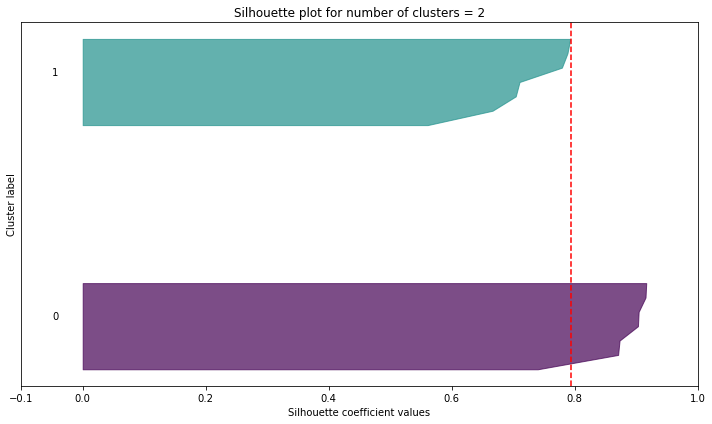

For number of clusters = 3, the average silhouette_score is : 0.7418102957409988


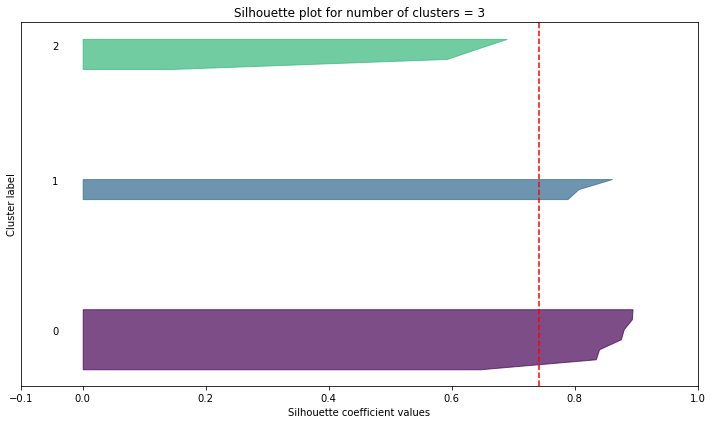

For number of clusters = 4, the average silhouette_score is : 0.5680138328649612


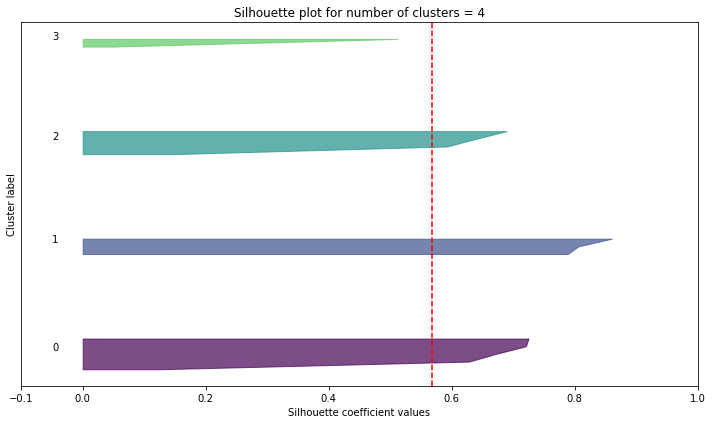

In [20]:
# Provided model_names
model_names = ['CCSM4', 'CESM1.2', 'CESM2', 'COSMOS', 'EC_Earth3.3', 'HADGEM3', 'MIROC4', 'Utrecht',
               'IPSLCM6A', 'GISS', 'LEEDS', 'NorESM-F', 'IPSLCM5A', 'IPSLCM5A2'][:len(rmsb)]  # Trim model_names to match rmsb length

# Create a new dataset as a Pandas DataFrame
rmsb_df = pd.DataFrame(
    {
        "RMSB": rmsb,
        "Model_Names": model_names,
    }
)

# Create a range of number of clusters to iterate over
cluster_range = range(2, 5)

# Iterate over each number of clusters
for num_clusters in cluster_range:

    # Assuming you have a numeric dataset for clustering (rmsb in this case)
    numeric_data = np.array(rmsb).reshape(-1, 1)

    # Create a KMeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the KMeans model to the data
    kmeans.fit(numeric_data)

    # Add cluster labels to the rmsb dataset
    rmsb_df["Cluster_Labels"] = kmeans.labels_

    # Compute the average silhouette score for the clustering
    silhouette_avg = silhouette_score(numeric_data, kmeans.labels_)
    print(f"For number of clusters = {num_clusters}, the average silhouette_score is :", silhouette_avg)

    # Compute the silhouette score for each individual sample
    sample_silhouette_values = silhouette_samples(numeric_data, kmeans.labels_)

    # Plotting the silhouette plot
    plt.figure(figsize=(10, 6))

    # Initialize a lower y coordinate for the silhouette plot
    y_lower = 10

    # Iterate over each cluster to plot its silhouette values
    for i in range(num_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        ith_cluster_silhouette_values.sort()

        # Compute the size of the current cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        # Calculate the upper y coordinate for the silhouette plot
        y_upper = y_lower + size_cluster_i

        # Define color for the current cluster
        color = plt.cm.viridis(i / num_clusters)

        # Fill the silhouette plot for the current cluster with the appropriate color
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Add a text annotation for the cluster label
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Update the lower y coordinate for the next cluster
        y_lower = y_upper + 10

    # Add title and labels to the silhouette plot
    plt.title(f"Silhouette plot for number of clusters = {num_clusters}")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    # Add a vertical line representing the average silhouette score
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Clear the y-axis labels/ticks
    plt.yticks([])

    # Set custom ticks for the x-axis
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Adjust layout
    plt.tight_layout()

    # Setting output path
    path = '/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/'

    # Save the silhouette plot as an image file
    plt.savefig(path + f"Silhouette_plot_{num_clusters}_clusters.pdf")

    # Display the silhouette plot
    plt.show()

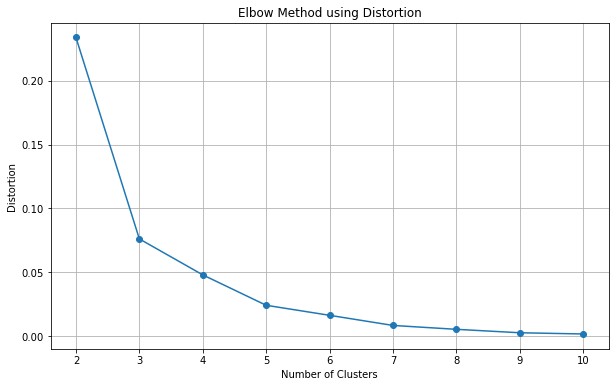

In [21]:
# Initialize a list to store distortion values
distortions = []

# Create a range of number of clusters to iterate over
cluster_range = range(2, 11)

# Iterate over each number of clusters
for num_clusters in cluster_range:
    # Assuming you have a numeric dataset for clustering (rmsb in this case)
    numeric_data = np.array(rmsb).reshape(-1, 1)

    # Create a KMeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the KMeans model to the data
    kmeans.fit(numeric_data)

    # Calculate distortion (WCSS) and append to the list
    distortions.append(kmeans.inertia_)

# Plotting the distortion values
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, distortions, marker='o', linestyle='-')
plt.title('Elbow Method using Distortion')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.xticks(cluster_range)
plt.grid(True)

# Setting output path
path = '/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/'

# Save the silhouette plot as an image file
plt.savefig(path + "Distortion_Elbow_Method.pdf")
plt.show()

# CLUSTER ANOMOLY PLOTS

| Index | Model Name  |
|-------|-------------|
| 0     | CCSM4       |
| 1     | CESM1.2     |
| 2     | CESM2       |
| 3     | COSMOS      |
| 4     | EC_Earth3.3 |
| 5     | HADGEM3     |
| 6     | MIROC4      |
| 7     | Utrecht     |
| 8     | IPSLCM6A    |
| 9     | GISS        |
| 10    | LEEDS       |
| 11    | NorESM-F    |
| 12    | IPSLCM5A    |
| 13    | IPSLCM5A2   |

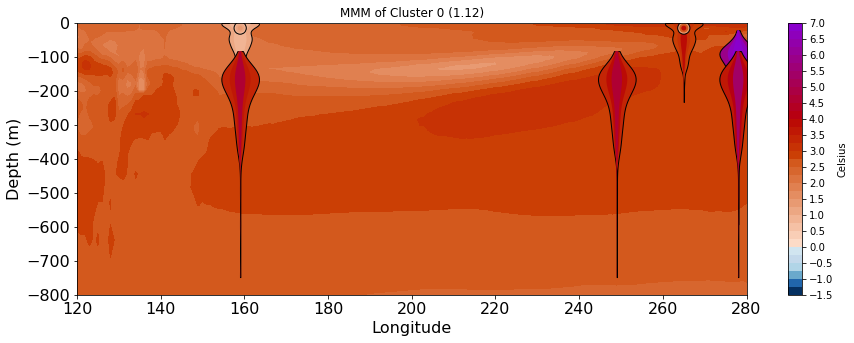

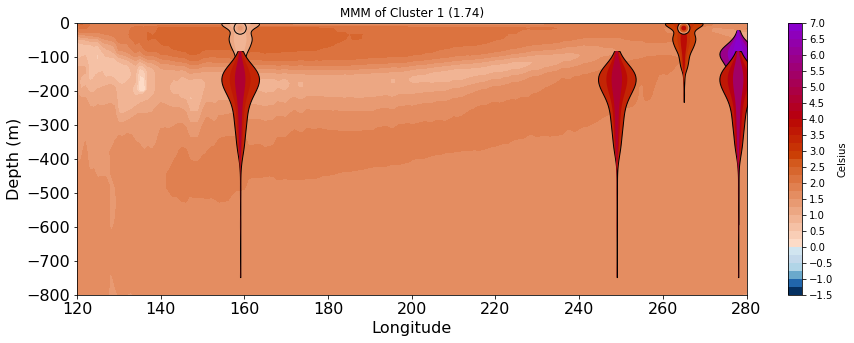

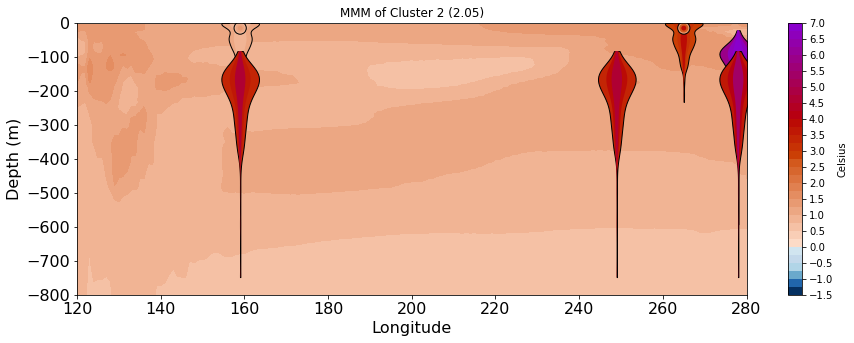

In [22]:
# Specify indices for anom_files1, anom_files2
anom_files1_indices = [1, 2, 4, 5, 6, 7, 10]
anom_files2_indices = [0, 3, 8]
anom_files3_indices = [9, 11, 12, 13]

# Create new lists with the Datasets at the specified indices
anom_files1 = [anom_files[i] for i in anom_files1_indices]
anom_files2 = [anom_files[i] for i in anom_files2_indices]
anom_files3 = [anom_files[i] for i in anom_files3_indices]

# Remove 'time' variable from anom_files2 and anom_files3
for ds in anom_files2:
    if "time" in ds.coords:
        ds = ds.drop("time")

for ds in anom_files3:
    if "time" in ds.coords:
        ds = ds.drop("time")

# Concatenate Datasets in anom_files1, anom_files2, and anom_files3 along a new dimension (e.g., 'ensemble')
concatenated_anom_files1 = xr.concat(anom_files1, dim="ensemble", coords="minimal")
concatenated_anom_files2 = xr.concat(anom_files2, dim="ensemble", coords="minimal")
concatenated_anom_files3 = xr.concat(anom_files3, dim="ensemble", coords="minimal")

# Calculate the mean along the 'TEMP' dimension for each set
clustermmm_temp1 = concatenated_anom_files1["TEMP"].mean(dim="ensemble")
clustermmm_temp2 = concatenated_anom_files2["TEMP"].mean(dim="ensemble")
clustermmm_temp3 = concatenated_anom_files3["TEMP"].mean(dim="ensemble")

# Print cluster mean temperature
#print("\nCluster Multi-Model Mean for anom_files1:")
#print(clustermmm_temp1)
#print("\nCluster Multi-Model Mean for anom_files2:")
#print(clustermmm_temp2)
#print("\nCluster Multi-Model Mean for anom_files3:")
#print(clustermmm_temp3)

plot(
    clustermmm_temp1.lon,
    -clustermmm_temp1["lev"],
    clustermmm_temp1,
    title="MMM of Cluster 0",
    pos95=dsa["pos95"],
    med=dsa["median"],
    neg95=dsa["neg95"],
    lon_sites=dsa["longitude"],
    species_sites=dsa["species"],
    scatter_X=alk_sites["longitude"],
    scatter_Y=alk_sites["depth"],
    scatter_med=alk_sites["median"],
    scatter_pos95=alk_sites["pos95"],
    scatter_neg95=alk_sites["neg95"],
    rmsb=1.12,
    fig_name="MMM_Cluster0.pdf",
)

plot(
    clustermmm_temp2.lon,
    -clustermmm_temp2["lev"],
    clustermmm_temp2,
    title="MMM of Cluster 1",
    pos95=dsa["pos95"],
    med=dsa["median"],
    neg95=dsa["neg95"],
    lon_sites=dsa["longitude"],
    species_sites=dsa["species"],
    scatter_X=alk_sites["longitude"],
    scatter_Y=alk_sites["depth"],
    scatter_med=alk_sites["median"],
    scatter_pos95=alk_sites["pos95"],
    scatter_neg95=alk_sites["neg95"],
    rmsb=1.74,
    fig_name="MMM_Cluster1.pdf",
)

plot(
    clustermmm_temp3.lon,
    -clustermmm_temp3["lev"],
    clustermmm_temp3,
    title="MMM of Cluster 2",
    pos95=dsa["pos95"],
    med=dsa["median"],
    neg95=dsa["neg95"],
    lon_sites=dsa["longitude"],
    species_sites=dsa["species"],
    scatter_X=alk_sites["longitude"],
    scatter_Y=alk_sites["depth"],
    scatter_med=alk_sites["median"],
    scatter_pos95=alk_sites["pos95"],
    scatter_neg95=alk_sites["neg95"],
    rmsb=2.05,
    fig_name="MMM_Cluster2.pdf",
)

| Cluster 0 | Cluster 1 | Cluster 2  |
|------------|-----------|-----------|
| CESM1.2    | CCSM4     | IPSLCM5A  |
| CESM2      | COSMOS    | GISS      |
| EC_Earth3.3| IPSLCM6A  | NorESM-F  |
| HADGEM3    |           | IPSLCM5A2 |
| MIROC4     |           |           |
| Utrecht    |           |           |
|  LEEDS     |           |           |

# BIAS PER SPECIES PER MODEL PLOTS

'''
Be aware that you must re-run the bias code as the you will get an error about 'model' not being in the dataset.
This only matters if you have run the cluster analysis code as when you run that code, you lose bias for root mean squared bias.
'''

## FINDING RGBA VALUES FOR BIAS IN EACH MODEL*SPECIES^-1

In [23]:
# Assuming desired_columns is defined earlier in your code
desired_columns = ['Bias', 'species_lon', 'species']

# Create an empty list to store dataframes
model_bias = []

# Iterate over each model
for model_name in result_dataset.models.values:
    # Access data for the current model
    model_data = result_dataset.sel(models=model_name)
    
    # Convert the subset to a Pandas DataFrame and reset the index
    model_dataframe = model_data.to_dataframe().reset_index()

    # Take the absolute value of the 'Bias' column
    #model_dataframe['Bias'] = np.abs(model_dataframe['Bias'])
    
    # Select only the desired columns
    model_dataframe_subset = model_dataframe[desired_columns]
    
    # Append the dataframe to the list
    model_bias.append(model_dataframe_subset)

len(model_bias)

16

In [24]:
# Function to generate color swatches
def generate_color_swatches_bias(values):
    # Define the coolwarm colormap
    cmap = plt.cm.coolwarm

    # Create a custom colormap
    norm = plt.Normalize(vmin=-5, vmax=5)
    rgba_values = cmap(norm(values))

    return rgba_values

# List to store RGBA values for each model
model_biasrgba_values = []

# Iterate over each model in model_bias list
for model_data in model_bias:
    # Extract the bias values for the specific model
    model_bias_values = model_data['Bias'].values
    #print(model_bias_values)
    #model_bias_values = np.abs(model_bias_values)

    # Generate color swatches for the bias values of the specific model
    bias_rgba_values = generate_color_swatches_bias(model_bias_values)

    #print(bias_rgba_values)
    
    # Append the RGBA values to the list
    model_biasrgba_values.append(bias_rgba_values)

    # Plot color swatches for 'neg95'
    #fig, axes = plt.subplots(1, len(bias_rgba_values), figsize=(len(bias_rgba_values), 2))
    #for i, rgba in enumerate(bias_rgba_values):
        #ax = axes[i]
        #ax.add_patch(plt.Rectangle((0, 0), 1, 1, fc=rgba))
        #ax.set_aspect('equal')
        #ax.set_xlim(0, 1)
        #ax.set_ylim(0, 1)
        #ax.axis('off')
    
    # Add colorbar
    #cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.05])  # [left, bottom, width, height]
    #cbar = ColorbarBase(cbar_ax, cmap=plt.cm.coolwarm, norm=Normalize(vmin=-5, vmax=5), orientation='horizontal')
    #cbar.set_label('Bias Values')

    #plt.subplots_adjust(wspace=0.2)
    #plt.show()

## CREAITNG GRIDDED PLOTTING FUNCITON

In [25]:
################################################################################################################
alk_sites = dsa.where(dsa['species'] == 'alkenones', drop=True) # This variable is needed to be set before using any grid plot
################################################################################################################
def bias_gridplot(X, Y, violin_bias_rgba_values, scatter_bias_rgba_values, title, lon_sites, species_sites, scatter_X, scatter_Y, rmsb, ax=None):
    """
    Function to create a combined plot with temperature contour, violin plots, and scatter points.

    Parameters:
    X (array-like): Array of x-axis values (longitude).
    Y (array-like): Array of y-axis values (depth).
    title (str): Title for the plot.
    lon_sites (array-like): Array of longitude values for sites.
    species_sites (array-like): Array of species names for sites.
    scatter_X (array-like): Array of x-axis values for scatter points.
    scatter_Y (array-like): Array of y-axis values for scatter points.
    df_filtered (DataFrame): Filtered DataFrame containing necessary data.
    fig_name (str): Name of the figure. Default is None.
    ax (matplotlib.axes.Axes): If provided, plot on this axis. Default is None.
    """
    # If ax is not provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 12))

    cmap = plt.cm.coolwarm

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Add grid lines
    ax.grid(True)
    
    # Set the title for the combined plot with rmsb
    ax.set_title(f"{title} ({rmsb})")

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)
    
    # Remove alkenones
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    species_sites_noAlks = species_sites[2:] 

    # Define custom positions for the violin plots on the x-axis
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    xpositions = np.array(lon_sites[2:])

    # Extract depth data for each species for violin plots
    violin_data = [df_filtered[df_filtered['species'] == species_sites_noAlks[i]]['calc_depth'].values for i in range(len(xpositions))]   

    # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):
        
        # Create the violin plot with a custom color for the negative 95th percentile
        parts = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=9, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(violin_bias_rgba_values[i])  # Assign the custom color
            pc.set_edgecolor('black')  # Set the edge color to black
            pc.set_alpha(1)
            
    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    scatter_kwargs = {"marker": "o", "cmap": cmap, "vmin": -5, "vmax": 5}
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_bias_rgba_values[0], scatter_bias_rgba_values[1]], s=150, edgecolors="k", **scatter_kwargs, alpha=1)

    # If ax is not provided, show the plot
    if ax is None:
        plt.show()

    return cs

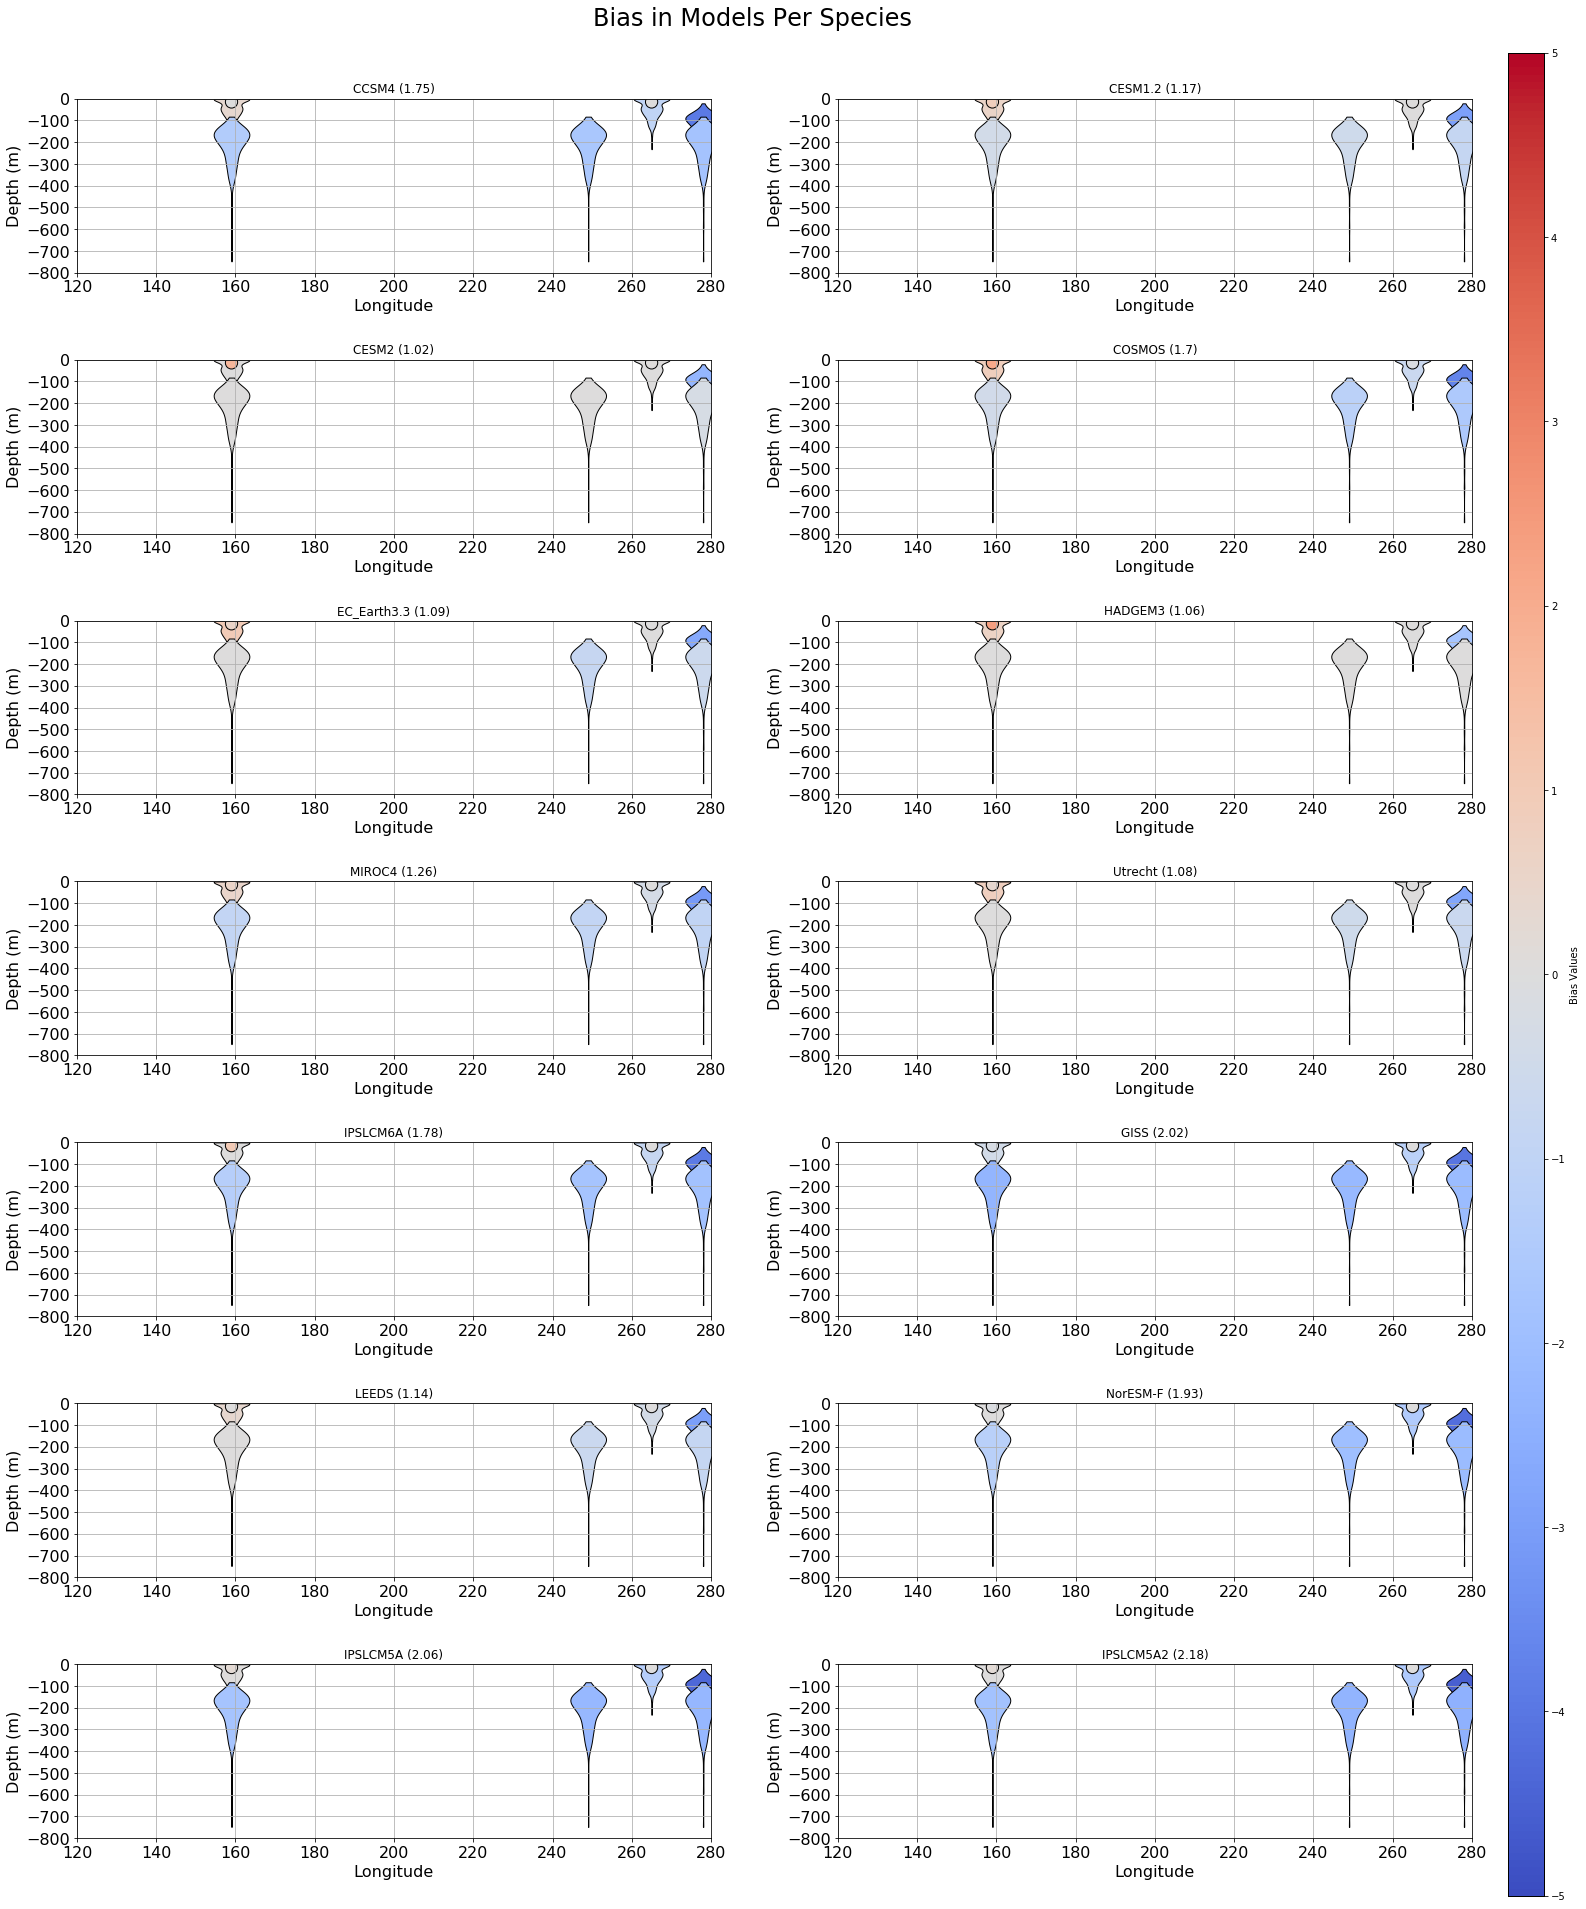

In [26]:
# List of model names
model_names = ['CCSM4', 'CESM1.2', 'CESM2', 'COSMOS', 'EC_Earth3.3', 'HADGEM3', 'MIROC4', 'Utrecht',
               'IPSLCM6A', 'GISS', 'LEEDS', 'NorESM-F', 'IPSLCM5A', 'IPSLCM5A2']

# Create a 7x2 subplot grid with specified figure size and vertical spacing
fig, axes = plt.subplots(7, 2, figsize=(25, 32), gridspec_kw={"hspace": 0.5})

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Iterate over each model name and corresponding data
for i, model_name in enumerate(model_names):
    # Call your gridplot function with specific arguments for the current model
    cs = bias_gridplot(
        multiplio.lon, 
        -multiplio['lev'], 
        violin_bias_rgba_values =  model_biasrgba_values[i][2:],
        scatter_bias_rgba_values = model_biasrgba_values[i][:2],
        title=model_names[i],
        lon_sites=dsa['longitude'],
        species_sites=dsa['species'],
        scatter_X=alk_sites['longitude'],
        scatter_Y=alk_sites['depth'],
         rmsb=round(float(result_dataset["RMSB"][i]), 2),
        ax=axes[i], 
    )
    # Create a colorbar for the current plot
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust the position if needed
    cbar = ColorbarBase(cbar_ax, cmap=plt.cm.coolwarm, norm=Normalize(vmin=-5, vmax=5), orientation='vertical')
    cbar.set_label('Bias Values')
    cbar.set_ticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

# Set an overall title with increased font size
fig.suptitle("Bias in Models Per Species", fontsize=24, y=0.92)

# Setting output path
path = '/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/'

# Save the figure as a large image file (e.g., PNG)
plt.savefig(path + "bias_grid_plot.pdf", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

| Cluster 0 | Cluster 1 | Cluster 2 |
|-----------|-----------|-----------|
| CESM1.2    | CCSM4     |   |
| CESM2      | COSMOS    | GISS      |
| EC_Earth3.3| IPSLCM6A | NorESM-F  |
| HADGEM3    |           | IPSLCM5A2 |
| MIROC4     |           | IPSLCM5A |
| Utrecht    |           |           |
|  LEEDS     |           |           |

# MCA Plots

In [27]:
pi_path = '/glade/u/home/nwrye/OceanTemps_Compiles/Modified_Cloud_Albedo/PreInd_ciso_T31_gx3v7_ALL.2901-3000.nc'
plio_path = '/glade/u/home/nwrye/OceanTemps_Compiles/Modified_Cloud_Albedo/Plio_ciso_T31_gx3v7_ALL.2901-3000.nc'

# Define new latitude and longitude arrays
new_lat = np.arange(-90, 90.5, 1)
new_lon = np.arange(0, 360, 1)

pi_ds = xr.open_dataset(pi_path)
plio_ds = xr.open_dataset(plio_path)

# Squeeze the dataset to remove singleton dimensions
plio_ds = plio_ds.squeeze()

# Convert z_t variable to meters (divide by 100)
plio_ds['z_t'] = plio_ds['z_t'] * (1/100)


# Rename variables TLONG and TLAT to lon and lat, respectively
plio_ds = plio_ds.rename({'TLONG': 'lon', 'TLAT': 'lat', 'z_t':'lev'})

# Create a new dataset with desired lat and lon coordinates
plio_ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                      'lon': (['lon'], new_lon)
                     })

# Create a regridder object using the source dataset (ds1) and the destination dataset (ds1_out)
regridder = xe.Regridder(plio_ds, plio_ds_out, 'nearest_s2d')

# Regrid the 'TEMP' variable using the regridder and convert it to a dataset
plio_dr_out = regridder(plio_ds['TEMP']).to_dataset(name='TEMP')

# Squeeze the dataset to remove singleton dimensions
pi_ds = pi_ds.squeeze()

# Convert z_t variable to meters (divide by 100)
pi_ds['z_t'] = pi_ds['z_t'] * (1/100)

# Rename variables TLONG and TLAT to lon and lat, respectively
pi_ds = pi_ds.rename({'TLONG': 'lon', 'TLAT': 'lat', 'z_t':'lev'})

# Create a new dataset with desired lat and lon coordinates
pi_ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                      'lon': (['lon'], new_lon)
                     })

# Create a regridder object using the source dataset (ds1) and the destination dataset (ds1_out)
regridder = xe.Regridder(pi_ds, pi_ds_out, 'nearest_s2d')

# Regrid the 'TEMP' variable using the regridder and convert it to a dataset
pi_dr_out = regridder(pi_ds['TEMP']).to_dataset(name='TEMP')

pi_dr_out = pi_dr_out.sel(lat=slice(-2, 2))
plio_dr_out = plio_dr_out.sel(lat=slice(-2, 2))

# Define the function to calculate horizontal temperature difference
def h_diff(plio_regridded, pi_regridded):
    # Calculate the temperature difference between Pliocene and Preindustrial datasets along the latitude axis
    diff = plio_regridded['TEMP'] - pi_regridded['TEMP']
    return diff

# Calculate the temperature difference using regridded datasets
anom_modified_albedo = h_diff(plio_dr_out, pi_dr_out)
output_path = '/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/Modified_Cloud_Albedo.nc'
anom_modified_albedo.to_netcdf(output_path)
anom_modified_albedo = anom_modified_albedo.mean(dim='lat', skipna=True)
print(anom_modified_albedo)

Overwrite existing file: nearest_s2d_116x100_181x360.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: nearest_s2d_116x100_181x360.nc 
 You can set reuse_weights=True to save computing time.


PermissionError: [Errno 13] Permission denied: b'/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/Modified_Cloud_Albedo.nc'

In [ ]:
# Define a variable needed for the function below
alk_sites = dsa.where(dsa['species'] == 'alkenones', drop=True)  # This variable is needed to be set before using Combined Plot function

def plot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites, scatter_X, scatter_Y, scatter_med, scatter_pos95, scatter_neg95, rmsb, fig_name):
    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15, 5))

    # Define your contour levels
    contour_levels = [-1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0]

    # Define your custom colors and normalize them to the range [0, 1]
    colors = [
        (5/255, 48/255, 97/255),     # Very Dark Blue
        (33/255, 102/255, 172/255),  # Dark Blue
        (106/255, 169/255, 204/255), # Blue
        (177/255, 213/255, 231/255), # Light Blue
        (196/255, 217/255, 235/255), # Light Blue
        (209/255, 229/255, 240/255), # Very Light Blue
        (253/255, 219/255, 199/255), # Very Light Orange
        (249/255, 206/255, 182/255), # Light Orange
        (245/255, 193/255, 165/255), # Light Orange
        (241/255, 180/255, 148/255), # Light Orange
        (236/255, 167/255, 131/255), # Light Orange
        (232/255, 154/255, 114/255), # Light Orange
        (228/255, 141/255, 97/255),  # Light Orange
        (224/255, 128/255, 80/255),  # Light Orange
        (220/255, 115/255, 63/255),  # Light Orange
        (215/255, 102/255, 46/255),  # Light Orange
        (211/255, 89/255, 29/255),   # Light Orange
        (207/255, 76/255, 12/255),   # Light Red
        (203/255, 63/255, 5/255),    # Light Red
        (199/255, 50/255, 5/255),    # Light Red
        (195/255, 37/255, 5/255),    # Light Red
        (191/255, 24/255, 5/255),    # Light Red
        (187/255, 11/255, 5/255),    # Dark Red
        (183/255, 0/255, 18/255),    # Dark Reddish Purple
        (179/255, 0/255, 35/255),    # Dark Purple
        (175/255, 0/255, 51/255),    # Deep Purple
        (171/255, 0/255, 68/255),    # Deep Blueish Purple
        (167/255, 0/255, 85/255),    # Deep Blue Purple
        (162/255, 0/255, 102/255),   # Deep Blue Purple
        (158/255, 0/255, 119/255),   # Deep Blue Purple
        (154/255, 0/255, 136/255),   # Deep Blue Purple
        (150/255, 0/255, 153/255),   # Deep Blue Purple
        (146/255, 0/255, 170/255),   # Deep Blue Purple
        (142/255, 0/255, 187/255),   # Deep Blue Purple
        (138/255, 0/255, 204/255),   # Deep Blue Purple
    ]

    # Create a custom colormap
    cmap = ListedColormap(colors)

    # Set the normalization
    norm = plt.Normalize(vmin=-1.5, vmax=7)

    # Clip values above -1.5 to 7 for the temperature differences array
    diff_clipped = np.clip(diff, -1.5, 7)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the clipped temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff_clipped, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')
    cbar.set_ticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7])

    # Set the title for the combined plot
    ax.set_title(f"{title} ({rmsb})")
    
    # Remove alkenones
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    species_sites_noAlks = species_sites[2:] 

    # Define custom positions for the violin plots on the x-axis
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    xpositions = np.array(lon_sites[2:])

    # Extract depth data for each species for violin plots
    violin_data = [df_filtered[df_filtered['species'] == species_sites_noAlks[i]]['calc_depth'].values for i in range(len(xpositions))]   

    # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):
        
        # Create the violin plot with a custom color for the negative 95th percentile
        parts = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=9, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(neg95rgba_values[i])  # Assign the custom color
            pc.set_edgecolor('black')  # Set the edge color to black
            pc.set_alpha(1)
        
        # Create the violin plot with a custom color for the median
        parts1 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=5, showextrema=False)
        for pc in parts1['bodies']:
            pc.set_facecolor(medrgba_values[i])  # Assign the custom color
            pc.set_alpha(1)
        
        # Create the violin plot with a custom color for the positive 95th percentile
        parts2 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=2.5, showextrema=False)
        for pc in parts2['bodies']:
            pc.set_facecolor(pos95rgba_values[i])  # Assign the custom color
            pc.set_alpha(1)
            
    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    scatter_kwargs = {"marker": "o", "cmap": cmap, "vmin": -1.5, "vmax": 7}
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_neg95[0], scatter_neg95[1]], s=150, edgecolors="k", **scatter_kwargs)
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_med[0], scatter_med[1]], s=60, **scatter_kwargs)
    ax.scatter([scatter_X[0], scatter_X[1]], [scatter_Y[0], scatter_Y[1]], c=[scatter_pos95[0], scatter_pos95[1]], s=15, **scatter_kwargs)

    # Setting output path
    path = '/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/'

    # Save the figure as a large image file (e.g., PNG)
    plt.savefig(path + fig_name, dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

In [ ]:
result_dataset['RMSB']

In [ ]:
plot(
    clustermmm_temp1.lon,
    -clustermmm_temp1["lev"],
    clustermmm_temp1,
    title="MMM of Cluster 0",
    pos95=dsa["pos95"],
    med=dsa["median"],
    neg95=dsa["neg95"],
    lon_sites=dsa["longitude"],
    species_sites=dsa["species"],
    scatter_X=alk_sites["longitude"],
    scatter_Y=alk_sites["depth"],
    scatter_med=alk_sites["median"],
    scatter_pos95=alk_sites["pos95"],
    scatter_neg95=alk_sites["neg95"],
    rmsb=1.12,
    fig_name="MMM_Cluster0.pdf",
)

plot(
    clustermmm_temp2.lon,
    -clustermmm_temp2["lev"],
    clustermmm_temp2,
    title="MMM of Cluster 1",
    pos95=dsa["pos95"],
    med=dsa["median"],
    neg95=dsa["neg95"],
    lon_sites=dsa["longitude"],
    species_sites=dsa["species"],
    scatter_X=alk_sites["longitude"],
    scatter_Y=alk_sites["depth"],
    scatter_med=alk_sites["median"],
    scatter_pos95=alk_sites["pos95"],
    scatter_neg95=alk_sites["neg95"],
    rmsb=1.74,
    fig_name="MMM_Cluster1.pdf",
)

plot(
    clustermmm_temp3.lon,
    -clustermmm_temp3["lev"],
    clustermmm_temp3,
    title="MMM of Cluster 2",
    pos95=dsa["pos95"],
    med=dsa["median"],
    neg95=dsa["neg95"],
    lon_sites=dsa["longitude"],
    species_sites=dsa["species"],
    scatter_X=alk_sites["longitude"],
    scatter_Y=alk_sites["depth"],
    scatter_med=alk_sites["median"],
    scatter_pos95=alk_sites["pos95"],
    scatter_neg95=alk_sites["neg95"],
    rmsb=2.05,
    fig_name="MMM_Cluster2.pdf",
)

plot(
    anom_modified_albedo.lon,
    -anom_modified_albedo["lev"],
    anom_modified_albedo,
    title="MCA",
    pos95=dsa["pos95"],
    med=dsa["median"],
    neg95=dsa["neg95"],
    lon_sites=dsa["longitude"],
    species_sites=dsa["species"],
    scatter_X=alk_sites["longitude"],
    scatter_Y=alk_sites["depth"],
    scatter_med=alk_sites["median"],
    scatter_pos95=alk_sites["pos95"],
    scatter_neg95=alk_sites["neg95"],
    rmsb=1.28,
    fig_name="Modified_Cloud_Albedo.pdf",
)